# DenseNet-161 version 2 (Augmentation)

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
# The specific torch version for this code
!pip3 install torch===1.2.0 torchvision===0.4.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install typeguard

In [0]:
# Import libraries
from fastai import *
from fastai.vision import *
import random
bs = 32
random.seed(23)

In [ ]:
# unzip data
!unzip 'data-augmented.zip'

In [0]:
# Load data
path_img = Path('data-augmented')

# set batch size
bs = 32

# Normalize data based on Image net parameters
data = ImageDataBunch.from_folder(path=path_img, train='train', valid='valid', ds_tfms=get_transforms(),size=224, bs=bs)
data.normalize(imagenet_stats)


ImageDataBunch;

Train: LabelList (1692 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
FRII,FRII,FRII,FRII,FRII
Path: data-aug;

Valid: LabelList (553 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
FRII,FRII,FRII,FRII,FRII
Path: data-aug;

Test: None

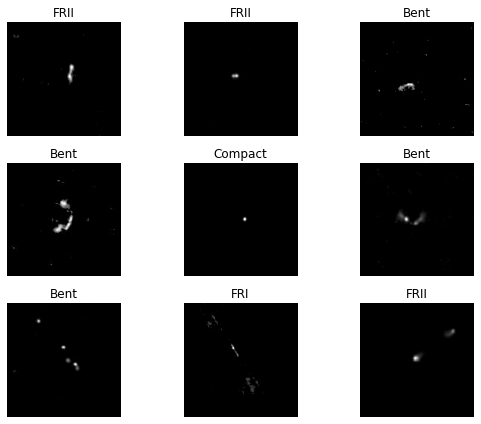

In [0]:
data.show_batch(rows=3, figsize=(8,6))

In [0]:
# Define model and metrics
learn = cnn_learner(data, models.densenet161, metrics=accuracy)

# Freeze the earlier layers and keep only the last layer trainable
learn.freeze()

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:01<00:00, 89.8MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-06
Min loss divided by 10: 1.15E-03


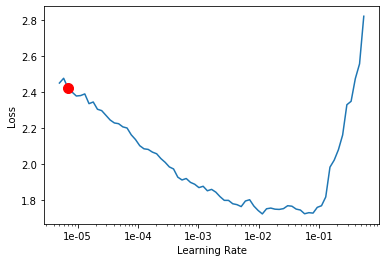

In [0]:
# Use lr_find to get the optimal learning rate
learn.lr_find(start_lr=1e-6, end_lr=1e1, wd=5e-3)
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,1.191238,0.758973,0.687161,01:23


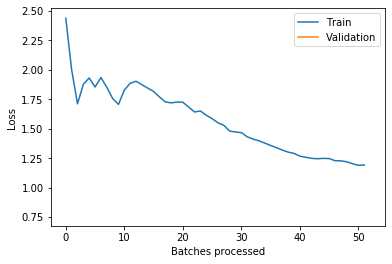

In [0]:
# Train the model using the lr from the plot for 1 epoch and check
learn.fit_one_cycle(1, max_lr=slice(3e-5,1e-2))

learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-05
Min loss divided by 10: 2.75E-05


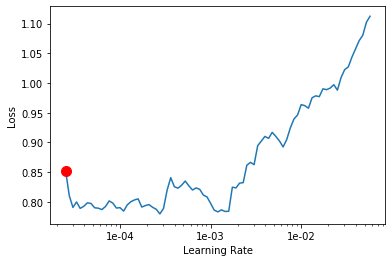

In [0]:
# Unfreeze all the layers and train the model from scratch
learn.unfreeze()

# Find the learning rate for the fully trainable model
learn.lr_find(start_lr=slice(1e-6, 1e-5), end_lr=slice(1e-2, 1e-1), wd=1e-3)
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.814962,0.826973,0.726944,01:38
1,0.707508,0.486820,0.828210,01:37
2,0.536746,0.459999,0.837251,01:37


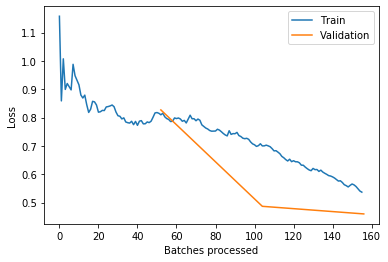

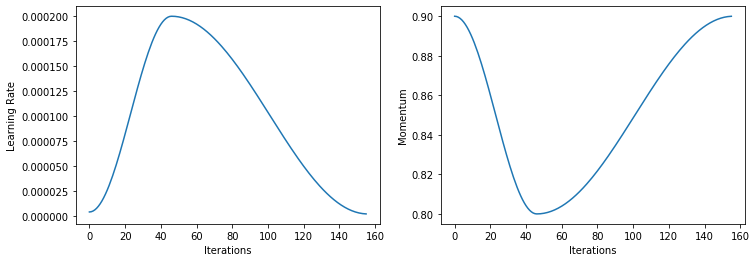

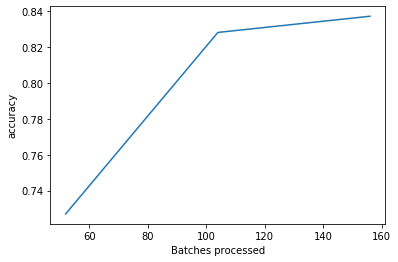

In [0]:
# Check with the obtained lr for few epochs
learn.fit_one_cycle(3, max_lr=slice(2.5e-5, 2e-4), wd=1e-3, moms=(0.9, 0.8))
learn.recorder.plot_losses()
learn.recorder.plot_lr(show_moms=True)
learn.recorder.plot_metrics()

epoch,train_loss,valid_loss,accuracy,time
0,0.541643,0.511657,0.819168,01:37
1,0.464660,0.455658,0.864376,01:38
2,0.416922,0.408438,0.857143,01:37
3,0.352223,0.393799,0.869801,01:38
4,0.309447,0.322128,0.891501,01:38
5,0.269707,0.297007,0.898734,01:38
6,0.233788,0.298643,0.909584,01:38
7,0.200397,0.262873,0.924051,01:37
8,0.183507,0.267025,0.915009,01:38
9,0.158864,0.259871,0.924051,01:38


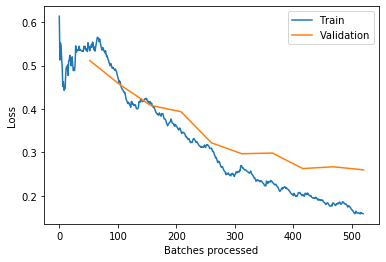

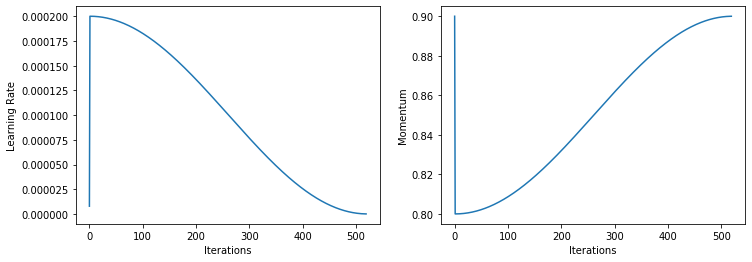

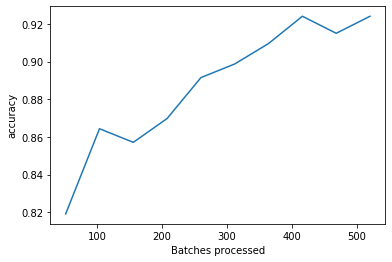

In [0]:
# Train the model
learn.fit_one_cycle(cyc_len=10, max_lr=slice(3e-5, 2e-4), wd=1e-3, moms=(0.9, 0.8))
learn.recorder.plot_losses()

learn.recorder.plot_lr(show_moms=True)
learn.recorder.plot_metrics()

In [0]:
# Save the model (saves it in models directory)
learn.save('RG_model_aug')

In [ ]:
# OPTIONAL: export the model as .pkl file
learn.export('RG_model_aug.pkl')

In [0]:
# Load the model for validation check and create interpreter
learn.load('RG_model_aug')
interp = ClassificationInterpretation.from_learner(learn)

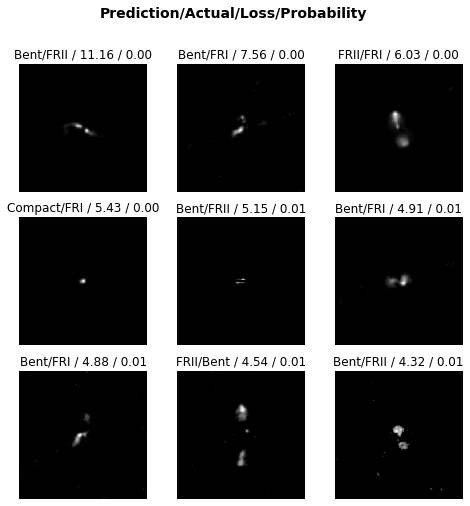

In [0]:
# Top losses from the model performance
interp.plot_top_losses(9, figsize=(8,8))

In [0]:
# OPTIONAL: Get the paths to top loss samples

losses, indexes = interp.top_losses(10)
top_loss_paths = data.valid_ds.x.items[indexes]
print(top_loss_paths)

[PosixPath('data-aug/valid/FRII/J151108.76+180153.2.jpeg') PosixPath('data-aug/valid/FRI/J143521.30-024051.7.jpg')
 PosixPath('data-aug/valid/FRI/FRI_original_J111634.70+291520.5.jpg_571d5bb3-95f9-48fb-a23d-29ae94e9798a.jpg')
 PosixPath('data-aug/valid/FRI/J141104.33-030043.3.jpeg') PosixPath('data-aug/valid/FRII/J144808.61+163439.5.jpg')
 PosixPath('data-aug/valid/FRI/J143825.92-010001.5.jpg')
 PosixPath('data-aug/valid/FRI/FRI_original_J103827.01+414852.9.jpg_357c17b6-8115-4faf-9a9c-d28533dcf989.jpg')
 PosixPath('data-aug/valid/Bent/J163032.36+285414.8.jpg') PosixPath('data-aug/valid/FRII/J150721.94+200408.5.jpeg')
 PosixPath('data-aug/valid/FRII/J144919.01+210548.0.jpg')]


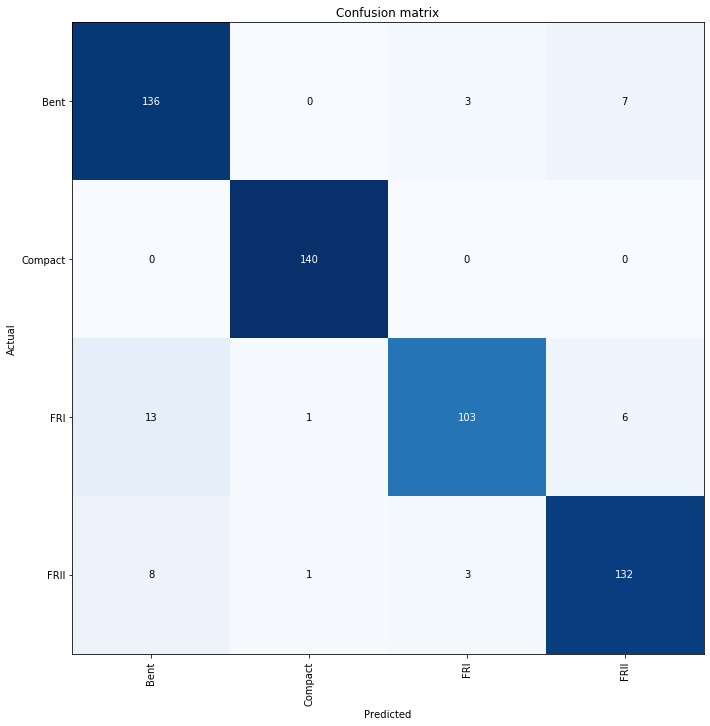

In [0]:
# Get the confusion matrix for validation data
interp.plot_confusion_matrix(figsize=(10,10))

## Predictions of the model on test data

In [ ]:
# TP: True Positive

import glob

image_list = glob.glob('data/test/*/*')

Bent, Pred_Bent = 0
Compact, Pred_Compact = 0
FRI, Pred_FRI=0
FRII, Pred_FRII = 0 

for each in image_list:
    img = open_image(each)
    each = each.split('/')
    rg_class = each[2]
    pred_class, pred_idx, outputs = learn.predict(img)
    pred_class = str(pred_class)
         
    if rg_class == 'Bent':
        Bent += 1
        if pred_class == 'Bent':
            Pred_Bent += 1
    elif rg_class == 'Compact':
        Compact += 1
        if pred_class == 'Compact':
            Pred_Compact += 1
    elif rg_class == 'FRI':
        FRI += 1
        if pred_class == 'FRI':
            Pred_FRI += 1
    elif rg_class == 'FRII':
        FRII += 1
        if pred_class == 'FRII':
            Pred_FRII += 1
            
    
print('Bent TP: ' + str(Pred_Bent) + '/' + str(Bent))
print('Compact TP: ' + str(Pred_Compact) + '/' + str(Compact))
print('FRI TP: ' + str(Pred_FRI) + '/' + str(FRI) )
print('FRII TP: ' + str(Pred_FRII) + '/' + str(FRII) )

Bent accuracy: 96/103
Compact accuracy: 92/100
FR1 accuracy: 95/100
FR2 accuracy: 92/101


## Another way to get the results on Test data

In [0]:
# The data-augmented folder contains the 'test' directory
# Provide the 'test' directory as input to 'valid' parameter in defining ImageDataBunch 

path_img = Path('data-augmented')
data = ImageDataBunch.from_folder(path=path_img, train='train', valid='test', ds_tfms=get_transforms(),size=224, bs=bs)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (1692 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
FRII,FRII,FRII,FRII,FRII
Path: data-aug;

Valid: LabelList (404 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Compact,Compact,Compact,Compact,Compact
Path: data-aug;

Test: None

In [0]:
# Define the architecture
learn = cnn_learner(data, models.densenet161, metrics=[accuracy])

In [0]:
# Load the trained and saved model
learn = learn.load('models/RG_model_aug')

In [0]:
# Get the interpreter
interp = ClassificationInterpretation.from_learner(learn)

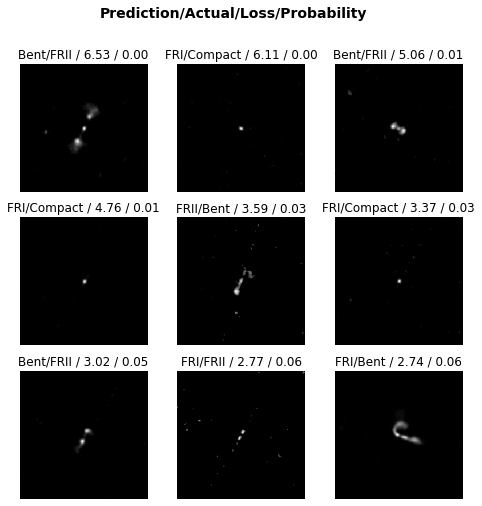

In [0]:
# Plot top losses from the test data
interp.plot_top_losses(9, figsize=(8,8))

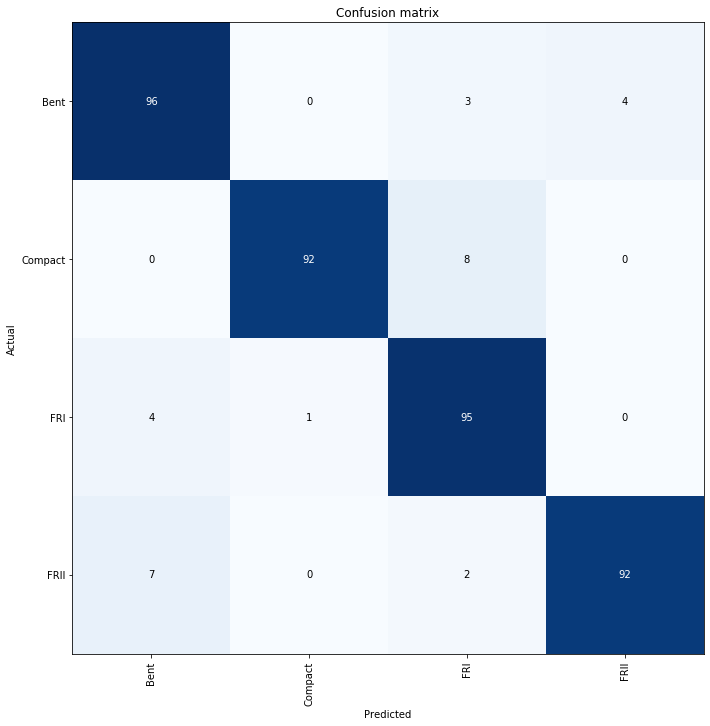

In [0]:
interp.plot_confusion_matrix(figsize=(10,10))